# 準備

In [ ]:
# バージョン指定時にコメントアウト
#!pip install torch==1.7.0
#!pip install torchvision==0.8.1

import torch
import torchvision
# バージョンの確認
print(torch.__version__) 
print(torchvision.__version__) 

1.7.0+cu101
0.8.1+cu101


In [ ]:
# Google ドライブにマウント
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/gan_sample/chapter2'

/content/gdrive/MyDrive/Colab Notebooks/gan_sample/chapter2


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optimizers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# データセットの作成

In [ ]:
np.random.seed(1234)
torch.manual_seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# データの取得
root = os.path.join('data', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])
mnist_train = \
    torchvision.datasets.MNIST(root=root,
                                      download=True,
                                      train=True,
                                      transform=transform)
mnist_test = \
    torchvision.datasets.MNIST(root=root,
                                      download=True,
                                      train=False,
                                      transform=transform)
train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)
test_dataloader = DataLoader(mnist_test,
                              batch_size=100,
                              shuffle=False)

# ネットワークの定義

In [ ]:
class VAE(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = Encoder(device=device)
        self.decoder = Decoder(device=device)

    def forward(self, x):
        # エンコーダ
        mean, var = self.encoder(x)
        # 潜在変数の作成
        z = self.reparameterize(mean, var)
        # デコーダ
        y = self.decoder(z)
        #生成画像yと潜在変数zが返り値
        return y, z

    # 潜在変数zの作成
    def reparameterize(self, mean, var):
        # 標準正規分布の作成
        eps = torch.randn(mean.size()).to(self.device)
        # 再パラメータ化トリック
        z = mean + torch.sqrt(var) * eps
        return z

    # 誤差の計算
    def lower_bound(self, x):
        # 平均と分散のベクトルを計算
        mean, var = self.encoder(x)
        # 平均と分散から潜在変数zを作成
        z = self.reparameterize(mean, var)
        # 潜在変数zから生成画像を作成
        y = self.decoder(z)
        # 再構成誤差
        reconst =  - torch.mean(torch.sum(x * torch.log(y)
                                       + (1 - x) * torch.log(1 - y),
                                       dim=1))
        # 正則化
        kl = - 1/2 * torch.mean(torch.sum(1
                                          + torch.log(var)
                                          - mean**2
                                          - var, dim=1))
        # 再構成誤差 + 正則化
        L =  reconst + kl

        return L

In [ ]:
class Encoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(784, 200)
        self.l_mean = nn.Linear(200, 10)
        self.l_var = nn.Linear(200, 10)

    def forward(self, x):
        # 784次元から200次元
        h = self.l1(x)
        # 活性化関数
        h = torch.relu(h)
        # 200次元から10次元の平均
        mean = self.l_mean(h)
        # 200次元から10次元の分散
        var = self.l_var(h)
        # 活性化関数softplus
        var = F.softplus(var)

        return mean, var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(10, 200)
        self.out = nn.Linear(200, 784)

    def forward(self, x):
        # 10次元から200次元
        h = self.l1(x)
        # 活性化関数
        h = torch.relu(h)
        # 200次元から784次元
        h = self.out(h)
        # シグモイド関数
        y = torch.sigmoid(h)

        return y

# 学習の実行

In [ ]:
# モデルの設定
model = VAE(device=device).to(device)
# 損失関数の設定
criterion = model.lower_bound
# 最適化関数の設定
optimizer = optimizers.Adam(model.parameters())

In [ ]:
print(model)

VAE(
  (encoder): Encoder(
    (l1): Linear(in_features=784, out_features=200, bias=True)
    (l_mean): Linear(in_features=200, out_features=10, bias=True)
    (l_var): Linear(in_features=200, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (l1): Linear(in_features=10, out_features=200, bias=True)
    (out): Linear(in_features=200, out_features=784, bias=True)
  )
)


In [ ]:
epochs = 10
# エポックのループ
for epoch in range(epochs):
    train_loss = 0.
    # バッチサイズのループ
    for (x, _) in train_dataloader:
        x = x.to(device)
        # 訓練モードへの切替        
        model.train()
        # 本物画像と生成画像の誤差計算
        loss = criterion(x)
        # 勾配の初期化
        optimizer.zero_grad()
        # 誤差の勾配計算
        loss.backward()
        # パラメータの更新        
        optimizer.step()
        # 訓練誤差の更新
        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    print('Epoch: {}, Loss: {:.3f}'.format(
        epoch+1,
        train_loss
    ))

Epoch: 1, Loss: 170.045
Epoch: 2, Loss: 129.957
Epoch: 3, Loss: 123.960
Epoch: 4, Loss: 120.843
Epoch: 5, Loss: 118.859
Epoch: 6, Loss: 117.465
Epoch: 7, Loss: 116.465
Epoch: 8, Loss: 115.654
Epoch: 9, Loss: 114.984
Epoch: 10, Loss: 114.457


# 画像の生成

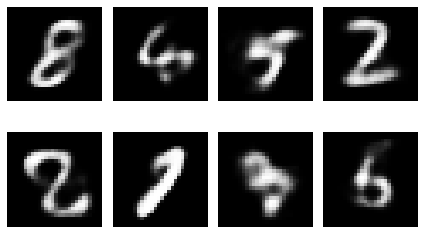

In [ ]:
# ノイズの作成数
batch_size=8
# デコーダ入力用に標準正規分布に従う10次元のノイズを作成
z = torch.randn(batch_size, 10, device = device)

# 評価モードへの切替 
model.eval()
# デコーダにノイズzを入力
images = model.decoder(z)
images = images.view(-1, 28, 28)
images = images.squeeze().detach().cpu().numpy()

for i, image in enumerate(images):
    plt.subplot(2, 4, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

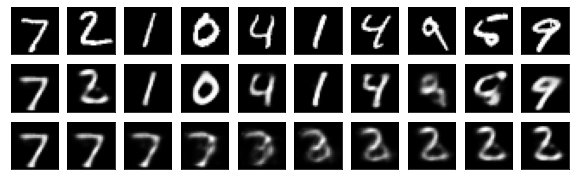

In [ ]:
fig = plt.figure(figsize=(10, 3))
model.eval()
for x, t in test_dataloader:
    # 本物画像
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    x = x.to(device)
    # 本物画像から生成画像
    y, z = model(x)
    y = y.view(-1, 28, 28)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    # 1つ目の画像と2つ目の画像の潜在変数を連続的に変化
    z1to0 = torch.cat([z[1] * (i * 0.1) + z[0] * ((9 - i) * 0.1) for i in range(10)]).reshape(10,10)
    y2 = model.decoder(z1to0).view(-1, 28, 28)
    for i, im in enumerate(y2.cpu().detach().numpy()):
      ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    break